In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from dateutil.parser import parse 

import warnings
import sys

warnings.filterwarnings('ignore')
!{sys.executable} --version

import os
os.chdir("C:/Users/Ruben/Desktop/Python Repository")

# plot settings
sns.set_style("whitegrid")
%matplotlib inline

Python 3.8.5


#### Load Data

In [120]:
df = pd.read_csv("AMLdata14_21.csv")
df.head(10)

,Date,State,County,Industry,SAR Count
0,14-Jan,Alabama,"Autauga County, AL",Depository Institution,8
1,14-Jan,Alabama,"Autauga County, AL",Money Service Business (MSB),14
2,14-Jan,Alabama,"Baldwin County, AL",Depository Institution,32
3,14-Jan,Alabama,"Baldwin County, AL",Money Service Business (MSB),36
4,14-Jan,Alabama,"Barbour County, AL",Depository Institution,4
5,14-Jan,Alabama,"Barbour County, AL",Money Service Business (MSB),3
6,14-Jan,Alabama,"Bibb County, AL",Money Service Business (MSB),5
7,14-Jan,Alabama,"Blount County, AL",Depository Institution,1
8,14-Jan,Alabama,"Blount County, AL",Money Service Business (MSB),4
9,14-Jan,Alabama,"Bullock County, AL",Money Service Business (MSB),3


In [121]:
df.dtypes

Date         object
State        object
County       object
Industry     object
SAR Count     int64
dtype: object

#### Exploratory Data Analysis

In [122]:
# Convert the Date column to date format
df['Date'] = pd.to_datetime(df['Date'], format='%y-%b', exact=True)
df

,Date,State,County,Industry,SAR Count
0,2014-01-01,Alabama,"Autauga County, AL",Depository Institution,8
1,2014-01-01,Alabama,"Autauga County, AL",Money Service Business (MSB),14
2,2014-01-01,Alabama,"Baldwin County, AL",Depository Institution,32
3,2014-01-01,Alabama,"Baldwin County, AL",Money Service Business (MSB),36
4,2014-01-01,Alabama,"Barbour County, AL",Depository Institution,4
...,...,...,...,...,...
530244,2021-12-01,Wyoming,"Teton County, Wyoming",Money Service Business (MSB),6
530245,2021-12-01,Wyoming,"Uinta County, Wyoming",Depository Institution,3
530246,2021-12-01,Wyoming,"Uinta County, Wyoming",Money Service Business (MSB),9
530247,2021-12-01,Wyoming,"Washakie County, Wyoming",Money Service Business (MSB),1


In [123]:
# aggregate the SAR_count values by date (monthly) 
data_ts = df.groupby("Date")["SAR Count"].sum()

#### Seasonal Plot of the Time Series

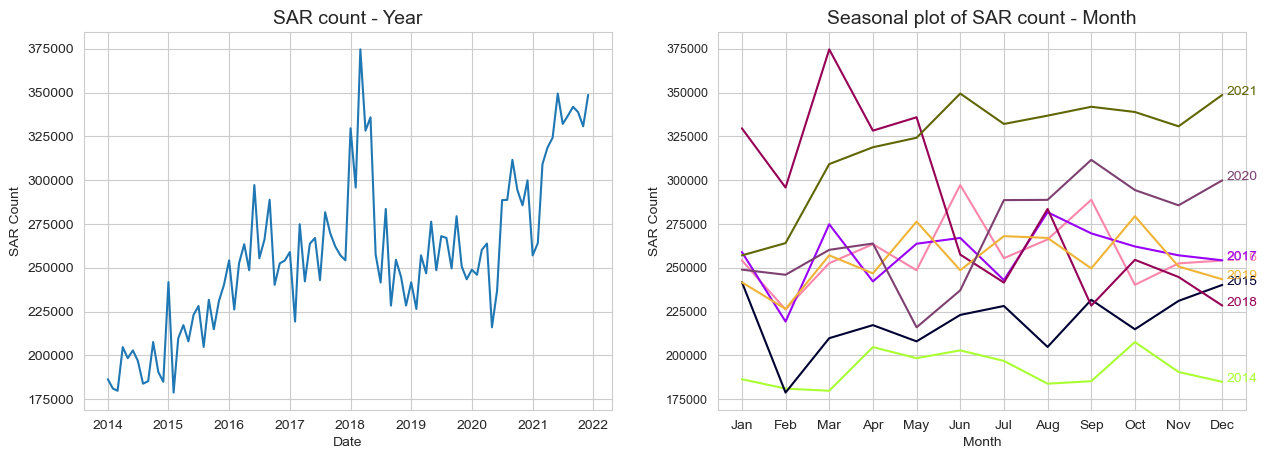

In [124]:
# prep data
df = data_ts.reset_index().copy()
df["Year"] = [d.year for d in df.Date]
df["Month"] = [d.strftime("%b") for d in df.Date]
years = df["Year"].unique()

# color scheme
np.random.seed(2)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# plot
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 100)
sns.lineplot(x = "Date", y = "SAR Count", data=df, ax=axes[0])

for i, y in enumerate(years):
    if i >= 0:        
        plt.plot("Month", "SAR Count", data=df.loc[df.Year==y, :], color=colors[i], label=y)
        plt.text(df.loc[df.Year==y, :].shape[0]-.9, df.loc[df.Year==y, "SAR Count"][-1:].values[0], y, fontsize=10, color=colors[i])

# titles
plt.gca().set(ylabel="SAR Count", xlabel="Month")
plt.yticks(fontsize=9, alpha=1)

axes[0].set_title("SAR count - Year", fontsize=14)
axes[1].set_title("Seasonal plot of SAR count - Month", fontsize=14)
plt.show()

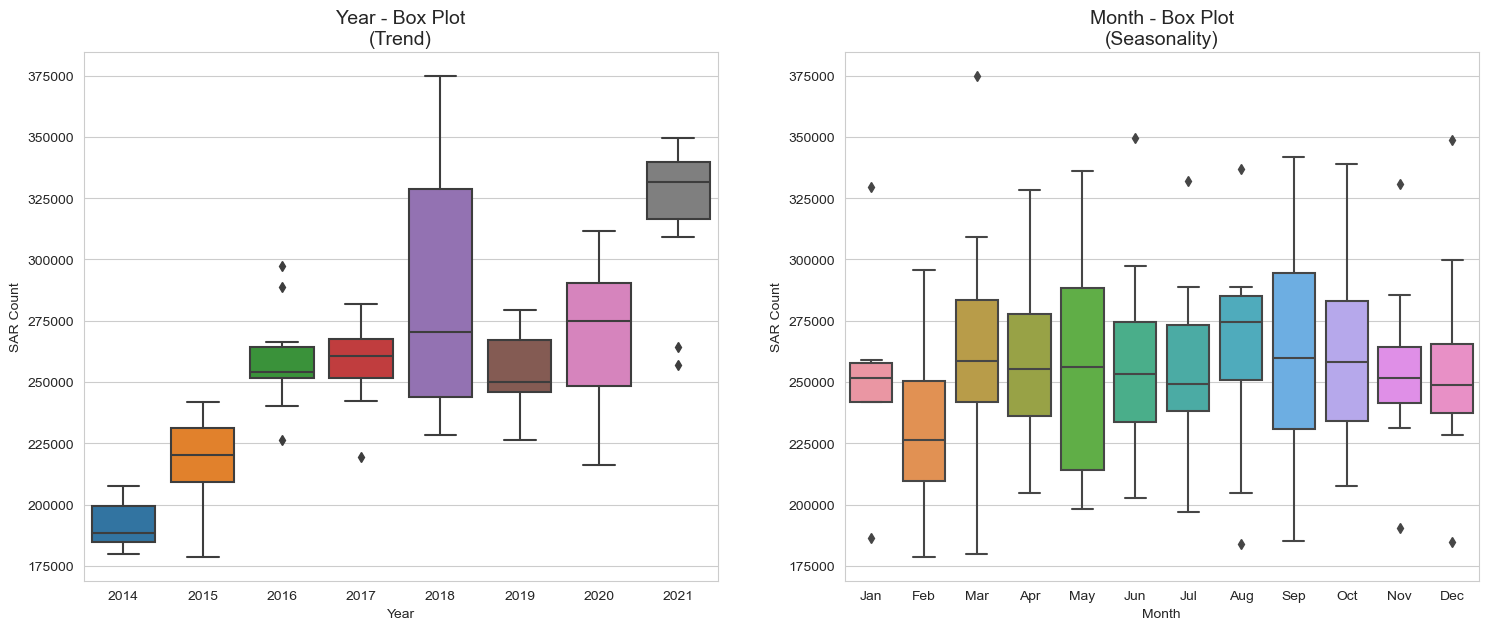

In [125]:
# boxplot Month (Seasonal) and Year (Trend) Distribution
fig, axes = plt.subplots(1, 2, figsize=(18,7), dpi= 100)
sns.boxplot(x="Year", y="SAR Count", data=df, ax=axes[0])
sns.boxplot(x="Month", y="SAR Count", data=df)

# title
axes[0].set_title("Year - Box Plot\n(Trend)", fontsize=14); 
axes[1].set_title("Month - Box Plot\n(Seasonality)", fontsize=14)
plt.show()

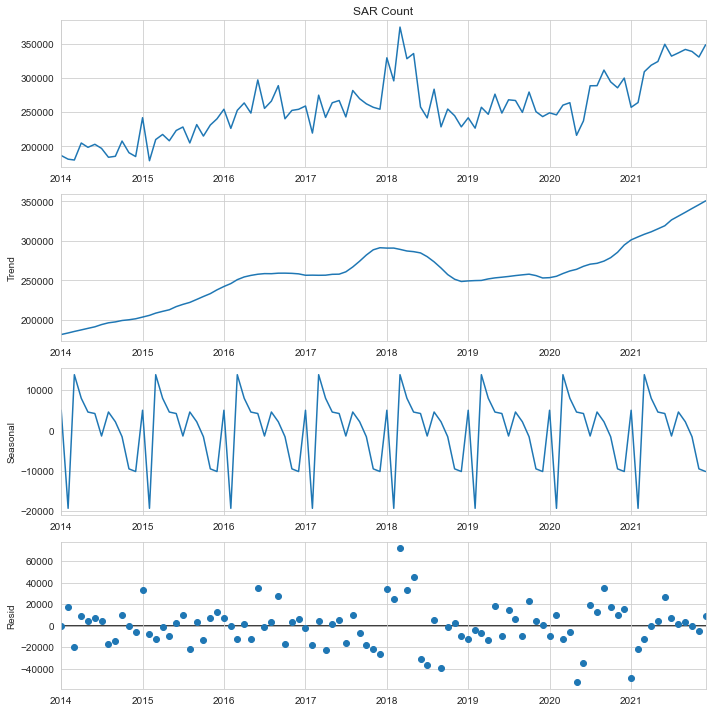

In [126]:
# data set
data_ts = pd.DataFrame(data_ts)

from statsmodels.tsa.seasonal import seasonal_decompose

# plot the additive decomposition of the time series into its components
plt.rcParams.update({'figure.figsize': (10,10)})
seasonal_decompose(data_ts["SAR Count"], model='additive', extrapolate_trend='freq').plot()
plt.show()

In [127]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
test = adfuller(data_ts.values, autolag='AIC')
print(f'ADF Statistic: {test[0]}')
print(f'p-value: {test[1]}')

ADF Statistic: -0.9833013359021409
p-value: 0.759305928879046


The p-value is equal to 0.7593 and > 0.05, therefore we cannot reject the null hypothesis and the time series is non-stationary. We will  implement differencing below to remove the non-stationarity.

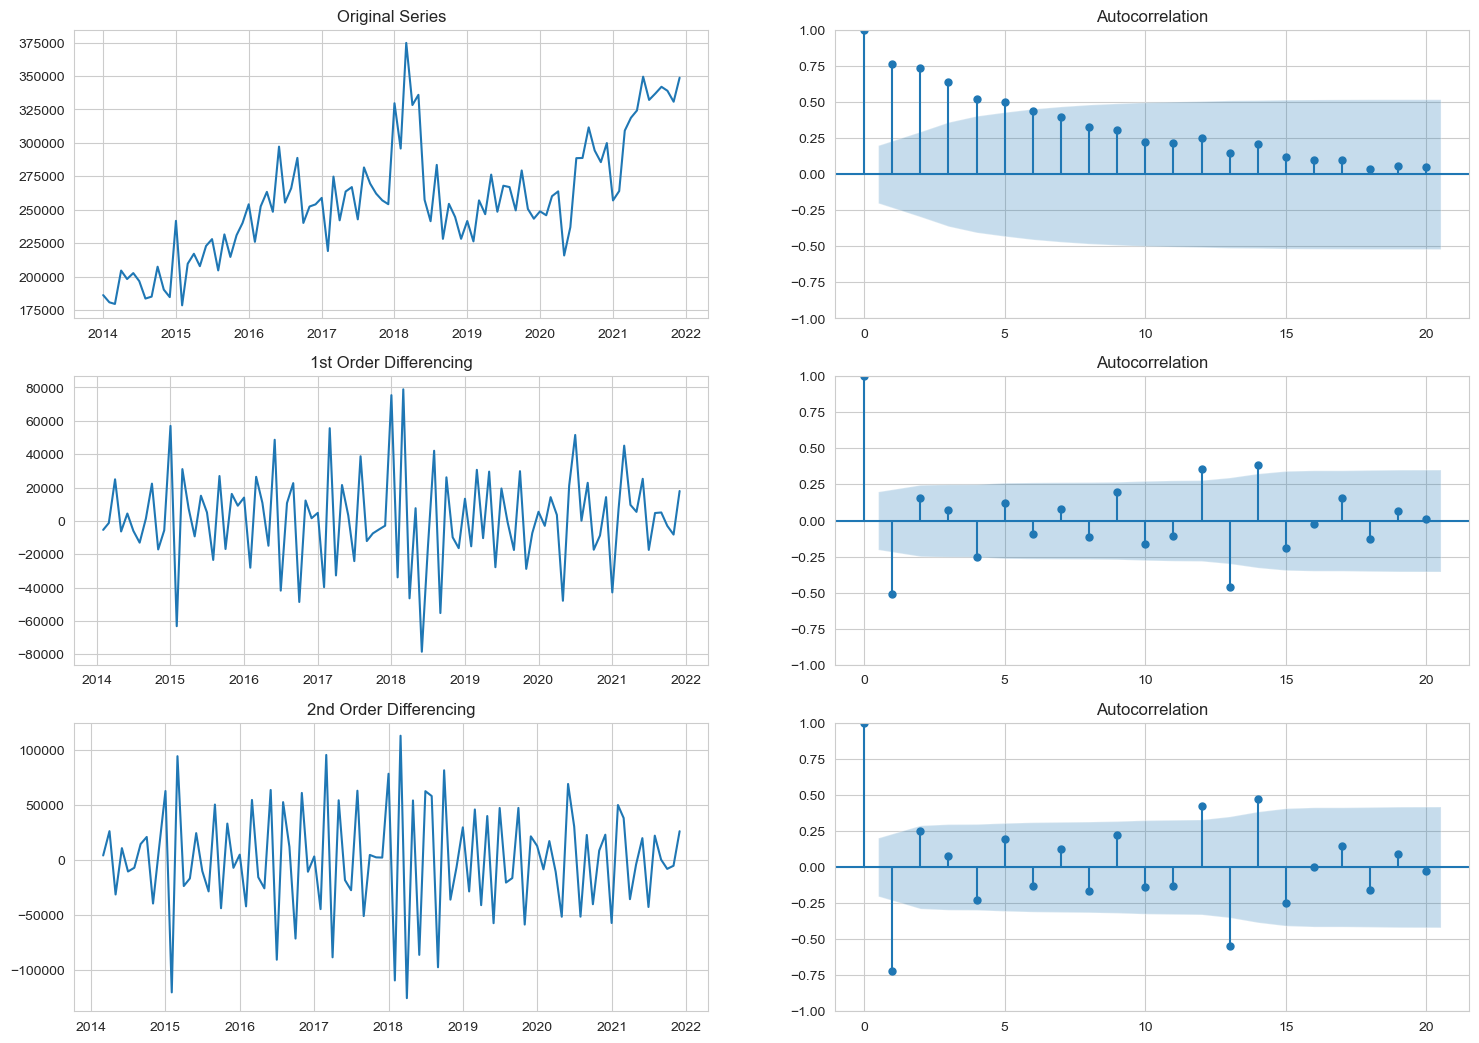

In [128]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(18,13), dpi= 100)
axes[0, 0].plot(data_ts["SAR Count"]); axes[0, 0].set_title("Original Series")
plot_acf(data_ts["SAR Count"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_ts["SAR Count"].diff()); axes[1, 0].set_title("1st Order Differencing")
plot_acf(data_ts["SAR Count"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_ts["SAR Count"].diff().diff()); axes[2, 0].set_title("2nd Order Differencing")
plot_acf(data_ts["SAR Count"].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

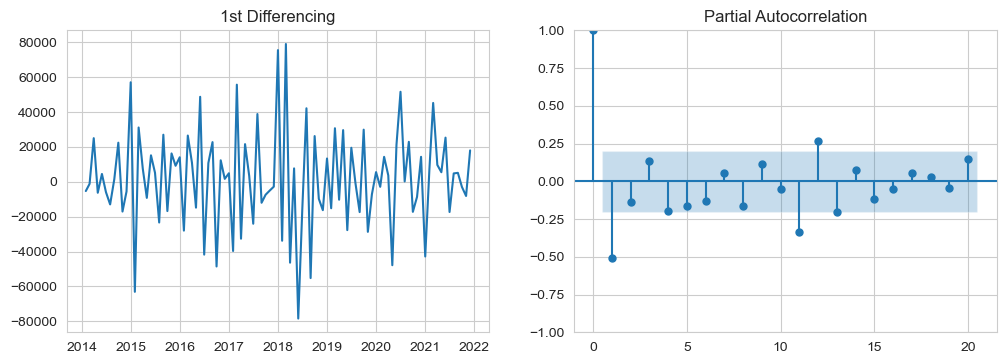

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi= 100)

# check the PACF plot - 1st differenced series
axes[0].plot(data_ts["SAR Count"].diff()); axes[0].set_title("1st Differencing")
plot_pacf(data_ts["SAR Count"].diff().dropna(), ax=axes[1])

plt.show()

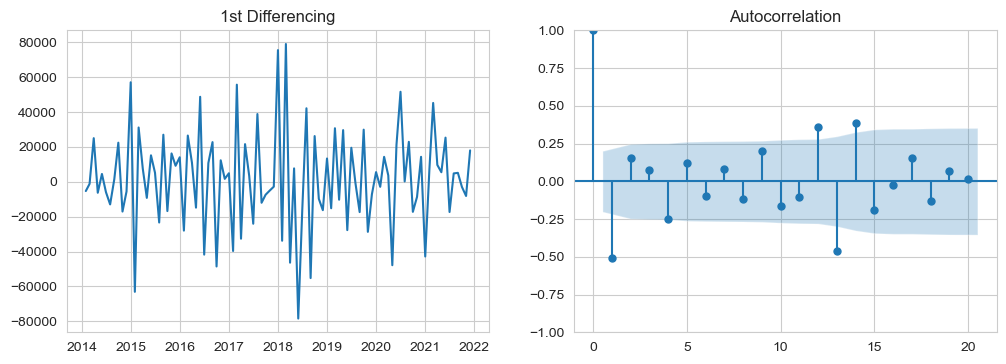

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi= 100)

# check the autocorrelation plot of the differenced series.
axes[0].plot(data_ts["SAR Count"].diff()); axes[0].set_title("1st Differencing")
plot_acf(data_ts["SAR Count"].diff().dropna(), ax=axes[1])

plt.show()

#### Build an ARIMA model

In [131]:
# Train dataset: time series from 2014-01 -- 2020-12
train = data_ts.loc[:'2020-12-01']
# Test dataset: 2021-01 -- 2021-12
test = data_ts.loc['2021-01-01':]

In [132]:
train.shape, test.shape

((84, 1), (12, 1))

In [133]:
warnings.filterwarnings('ignore')
#import statsmodels
import statsmodels.api as sm


# ARIMA(1,1,1) Model
model = sm.tsa.arima.ARIMA(data_ts["SAR Count"], order=(1,1,1))
model = sm.tsa.statespace.SARIMAX(train["SAR Count"], trend='c', order=(1,1,1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              SAR Count   No. Observations:                   84
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -960.885
Date:                Wed, 09 Mar 2022   AIC                           1929.769
Time:                        15:04:03   BIC                           1939.445
Sample:                    01-01-2014   HQIC                          1933.656
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2181.2597   2388.402      0.913      0.361   -2499.922    6862.441
ar.L1         -0.2648      0.194     -1.363      0.173      -0.646       0.116
ma.L1         -0.1409      0.221     -0.636      0.5

In [134]:
warnings.filterwarnings('ignore')
# rebuild the model without the MA1 term, i.e. ARIMA(1,1,0) model
model = sm.tsa.statespace.SARIMAX(train["SAR Count"], trend='c',  order=(1,1,0))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              SAR Count   No. Observations:                   84
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -961.210
Date:                Wed, 09 Mar 2022   AIC                           1928.420
Time:                        15:04:16   BIC                           1935.676
Sample:                    01-01-2014   HQIC                          1931.335
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2098.4014   2641.237      0.794      0.427   -3078.327    7275.130
ar.L1         -0.3709      0.047     -7.888      0.000      -0.463      -0.279
sigma2      6.065e+08      0.011   5.63e+10      0.0

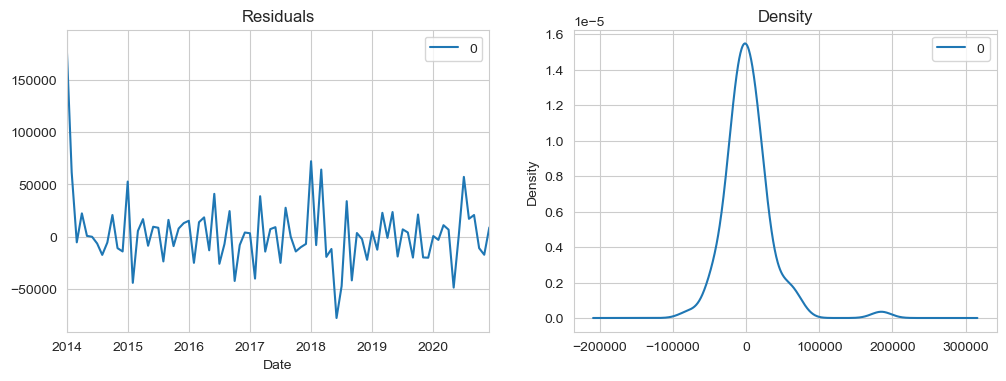

In [135]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi= 100)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### Prediction and Forecast on Year 2021

In [136]:
# In-sample one-step-ahead predictions
predict = model_fit.get_prediction()
predict_ci = predict.conf_int()

# Forecast for year 2021
forecast = model_fit.get_forecast(12, alpha=0.05)  # 95% conf
forecast_ci = forecast.conf_int()

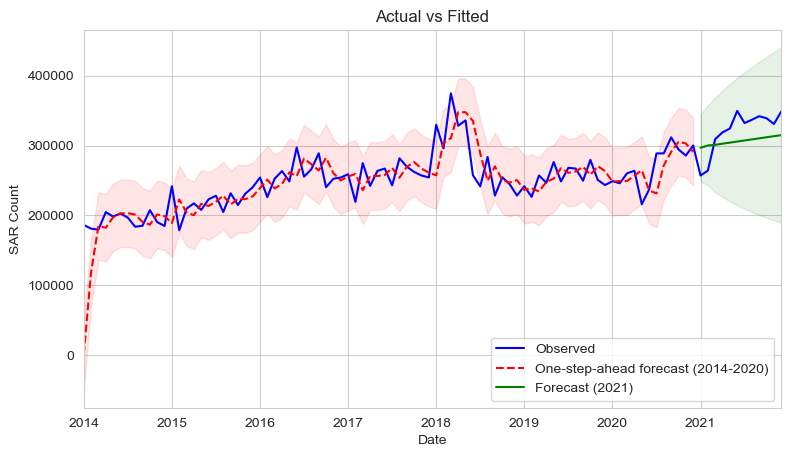

In [137]:
# graph
fig, ax = plt.subplots(figsize=(9,5), dpi = 100)
npre = 4
ax.set(title='Actual vs Fitted', xlabel='Date', ylabel="SAR Count")

# plot data points
data_ts["SAR Count"].plot(ax=ax, style='b-', label='Observed')

# plot predictions
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast (2014-2020)')
ci = predict_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# plot forecast
forecast.predicted_mean.plot(ax=ax, style='g', label='Forecast (2021)')
ci = forecast_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [138]:
from statsmodels.tsa.stattools import acf, pacf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))    # MAPE: Mean Absolute Percentage Error
    me = np.mean(forecast - actual)                             # ME: Mean Error
    mae = np.mean(np.abs(forecast - actual))                    # MAE: Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)                   # MPE: Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5                  # RMSE: Root Mean Squared Error 
    corr = np.corrcoef(forecast, actual)[0,1]                   # corr: Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                             # minmax: Min-Max Error
    acf1 = acf(forecast-actual)[1]                              # ACF1: Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(forecast.predicted_mean, test["SAR Count"])

{'mape': 0.08637363710993971,
 'me': -14666.42131761657,
 'mae': 27265.76727806267,
 'mpe': -0.03798114335322807,
 'rmse': 29044.27954554954,
 'acf1': 0.5563113412242334,
 'corr': 0.8134389437449323,
 'minmax': 0.0832969672724243}

##### Around 8.63% MAPE implies the model is approximately 91.37% accurate in predicting the next 12 observations.

In [139]:
#fit ARIMA model on total dataset and forecasting on 2022
model = sm.tsa.statespace.SARIMAX(data_ts["SAR Count"], trend='c', order=(1,1,0))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              SAR Count   No. Observations:                   96
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1098.116
Date:                Wed, 09 Mar 2022   AIC                           2202.232
Time:                        15:06:24   BIC                           2209.894
Sample:                    01-01-2014   HQIC                          2205.328
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2563.8568   2465.387      1.040      0.298   -2268.212    7395.926
ar.L1         -0.3607      0.047     -7.682      0.000      -0.453      -0.269
sigma2      5.925e+08      0.008   6.98e+10      0.0

In [140]:
# In-sample one-step-ahead predictions
predict = model_fit.get_prediction()
predict_ci = predict.conf_int()

# forecast on 2022
forecast = model_fit.get_forecast(12, alpha=0.05)  # 95% conf
forecast_ci = forecast.conf_int()

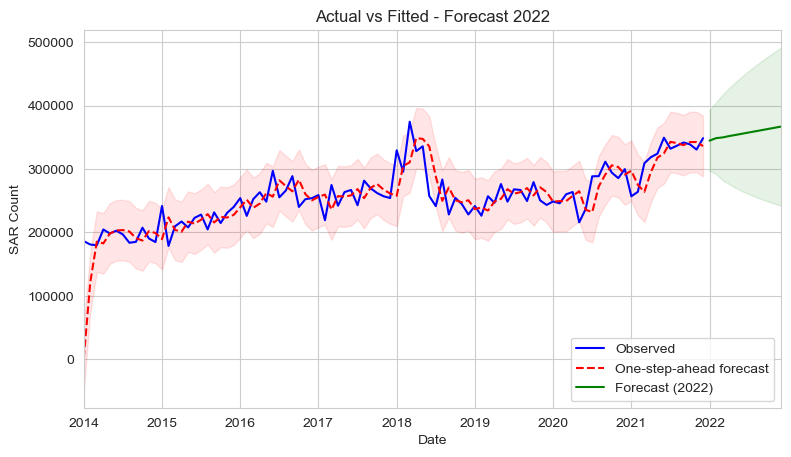

In [141]:
# graph
fig, ax = plt.subplots(figsize=(9,5), dpi = 100)
npre = 4
ax.set(title='Actual vs Fitted - Forecast 2022', xlabel='Date', ylabel="SAR Count")

# plot data points
data_ts["SAR Count"].plot(ax=ax, style='b-', label='Observed')

# plot prediction
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# plot forecast
forecast.predicted_mean.plot(ax=ax, style='g', label='Forecast (2022)')
ci = forecast_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [142]:
forecast_2022 = pd.DataFrame(forecast.predicted_mean) 
forecast_2022 = forecast_2022.rename(columns={'predicted_mean': "SAR Count"})

In [146]:
#forecasted values for 2022 by month

#resetting index to include the date column
forecast_2022.reset_index(inplace=True)
forecast_2022

,index,SAR Count
0,2022-01-01,344801.021164
1,2022-02-01,348773.412930
2,2022-03-01,349904.418747
3,2022-04-01,352060.319103
4,2022-05-01,353846.537608
5,2022-06-01,355766.101219
6,2022-07-01,357637.566940
7,2022-08-01,359526.381681
8,2022-09-01,361408.938591
9,2022-10-01,363293.752715


In [148]:
#formatting the data for the lineplot
forecast_2022 = forecast_2022.rename(columns = {"index":"Date"}) #renaming column
forecast_2022["SAR Count"] = forecast_2022["SAR Count"].astype(int) #changing data type
forecast_2022["Month"] = forecast_2022["Date"].dt.month_name() #extracting month from Date format
forecast_2022.drop("Date", axis=1, inplace=True) #dropping column Date

forecast_2022


,SAR Count,Month
0,344801,January
1,348773,February
2,349904,March
3,352060,April
4,353846,May
5,355766,June
6,357637,July
7,359526,August
8,361408,September
9,363293,October


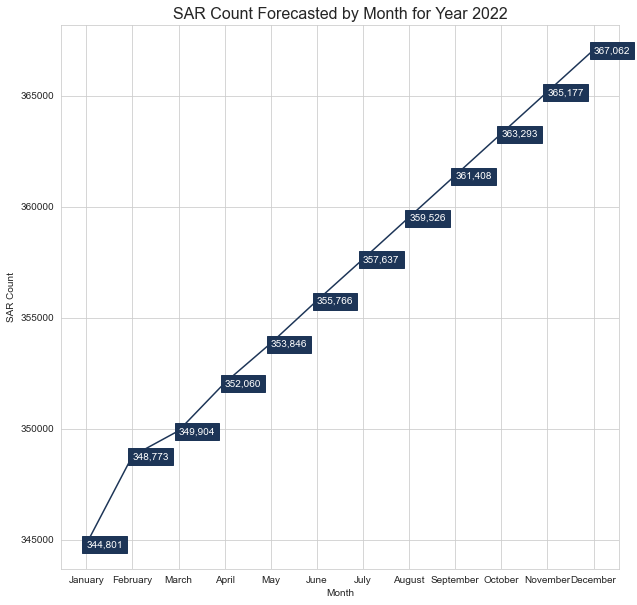

In [149]:
#line plot showing the forecasted values by month for 2022
ax = sns.lineplot(x="Month", y="SAR Count", data=forecast_2022, marker="*", color="#1D3557")
ax.set_title("SAR Count Forecasted by Month for Year 2022", fontsize=16)

for x, y in zip(forecast_2022["Month"], forecast_2022["SAR Count"]):
    plt.text(x=x, y=y-150,s="{:,.0f}".format(y), color="white").set_backgroundcolor("#1D3557")